Disclaimer : This notebook still needs more documentation and refinement!

#### importing the relevant libraries and preparing the data

In [1]:
import warnings
import itertools

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

X = pd.read_csv("data/dengue_features_train.csv")
y = pd.read_csv("data/dengue_labels_train.csv")

In [2]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

/home/susmeet/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
#setting a datetime index
y.index = pd.DatetimeIndex(X.week_start_date)

#seperating the data for the 2 cities
sj_cases = y.total_cases[y.city == 'sj']
iq_cases = y.total_cases[y.city == 'iq']

In [4]:
#month sampling
sj_monthly = sj_cases.resample('M').sum()
iq_monthly = iq_cases.resample('M').sum()

#### Analysing the auto correlation and partial auto correlation for our data at different lags

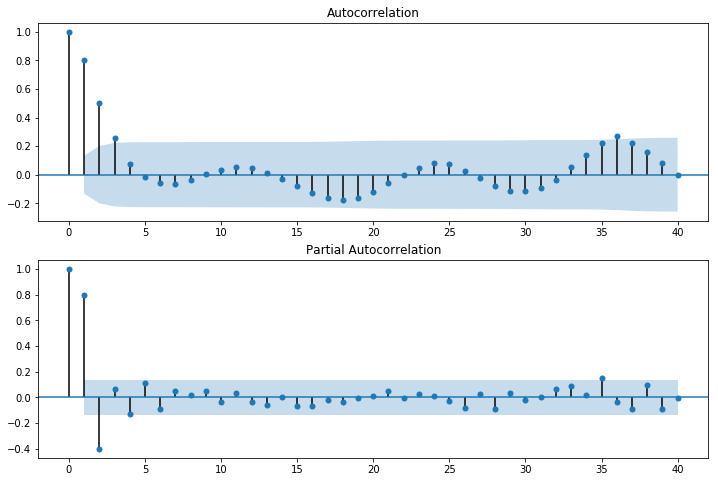

In [5]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sj_monthly, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sj_monthly, lags=40, ax=ax2)

 - **AR**: There is significant autocorrelation at lags upto 3 or even 4
 - **I**: Periodicity occurs at every 12th month, which is expected
 - **MA**: There is a clear partial auto correlation until lag 3

#### Tuning the hyperparameters for the Arima model
<font color='red'>This section is a work in progress</font>

In [19]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [27]:
pdq = [(3,0,1),
       (3,0,2),
       (3,0,3),
       (3,0,4),
       (4,0,1),
       (4,0,2),
       (4,0,3),
       (4,0,4),
       (1,0,3),
       (2,0,3),
       (1,0,4),
       (2,0,4)
      ]

In [28]:
seasonal_pdq = [
       (3,2,2,12),
       (4,2,1,12),
       (4,2,2,12),
       (2,2,3,12),
       (1,2,4,12),
       (2,2,4,12)
      ]

In [29]:
best_aic = 100000
optimal_pdq = 0
optimal_seasonal_pdq = 0

In [30]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

In [31]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(sj_monthly,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()
            
            if results.aic < best_aic:
                best_aic = results.aic
                optimal_pdq = param
                optimal_seasonal_pdq = param_seasonal

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(3, 0, 1)x(3, 2, 2, 12) - AIC:1948.1216709910318
ARIMA(3, 0, 1)x(4, 2, 1, 12) - AIC:1792.98024584508
ARIMA(3, 0, 1)x(4, 2, 2, 12) - AIC:1887.5702626520817
ARIMA(3, 0, 1)x(2, 2, 3, 12) - AIC:2060.075682342034
ARIMA(3, 0, 1)x(1, 2, 4, 12) - AIC:1756.576588342697
ARIMA(3, 0, 1)x(2, 2, 4, 12) - AIC:1779.1513850989454
ARIMA(3, 0, 2)x(3, 2, 2, 12) - AIC:2041.7954941730493
ARIMA(3, 0, 2)x(4, 2, 1, 12) - AIC:1865.7682356187702
ARIMA(3, 0, 2)x(4, 2, 2, 12) - AIC:1862.2750852137028
ARIMA(3, 0, 2)x(2, 2, 3, 12) - AIC:2058.3515171557874
ARIMA(3, 0, 2)x(1, 2, 4, 12) - AIC:1894.244422660541
ARIMA(3, 0, 2)x(2, 2, 4, 12) - AIC:1895.304638265609
ARIMA(3, 0, 3)x(3, 2, 2, 12) - AIC:2053.2150929897944
ARIMA(3, 0, 3)x(4, 2, 1, 12) - AIC:1862.8544904174007
ARIMA(3, 0, 3)x(4, 2, 2, 12) - AIC:1887.5840333685974
ARIMA(3, 0, 3)x(2, 2, 3, 12) - AIC:2043.7894154512041
ARIMA(3, 0, 3)x(1, 2, 4, 12) - AIC:1870.6500639464844
ARIMA(3, 0, 3)x(2, 2, 4, 12) - AIC:1882.0531677961656
ARIMA(3, 0, 4)x(3, 2, 2, 12) - AIC

> Following are the optimised hyperparameters for the arima or in this case sarimax model

In [32]:
best_aic

1718.9794281451739

In [33]:
optimal_pdq

(1, 0, 3)

In [34]:
optimal_seasonal_pdq

(2, 2, 4, 12)

> Fitting the model on optimised hyperparameters

In [6]:
mod = sm.tsa.statespace.SARIMAX(sj_monthly, order=(4,1,3), seasonal_order=(1,1,1,12))
results = mod.fit()
print (results.summary())

/home/susmeet/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                        total_cases   No. Observations:                  217
Model:             SARIMAX(4, 1, 3)x(1, 1, 1, 12)   Log Likelihood               -1279.931
Date:                            Fri, 11 May 2018   AIC                           2579.862
Time:                                    17:40:47   BIC                           2613.661
Sample:                                04-30-1990   HQIC                          2593.516
                                     - 04-30-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7038      0.631      2.701      0.007       0.467       2.940
ar.L2         -0.7084      1.452   

In [7]:
pred = results.predict()  

In [8]:
from sklearn.metrics import mean_absolute_error

In [9]:
mean_absolute_error(sj_monthly[:-1], pred.shift(-1).dropna().clip(0))

60.51614779317429

This result is clearly not good enough, we will need to do more data engineering in order to make a useful arima model

#### observing the seasonal differences

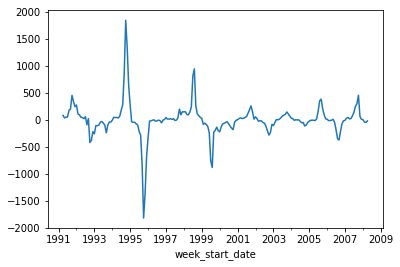

In [10]:
sj_monthly.diff(12).plot()

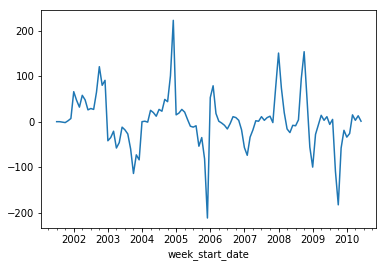

In [11]:
iq_monthly.diff(12).plot()

These plots clearly have a pattern to them.
**Next Step** shall be to utilise this pattern in creating a powerful arima model.